In [504]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wine example

In [505]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
wine = datasets.load_wine()

In [506]:
from sklearn.ensemble import RandomForestClassifier

features = [f.replace('/','_') for  f in wine['feature_names']]
target = 'class'
rs=42
fraction=0.1

#create daatframe with columns names as strings (LUX accepts only DataFrames with string columns names)
df_wine = pd.DataFrame(wine.data,columns=features)
df_wine[target] = wine.target

#train classifier
train, test = train_test_split(df_wine, random_state=rs)
clf = RandomForestClassifier(random_state=42)#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

1.0

## Without predictor uncertainty

In [507]:
#pick some instance from datasetr
i2e = train[features].sample(1, random_state=42).values
i2e

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


['IF od280_od315_of_diluted_wines <2.2050000429153442 THEN class = 2 # 0.9285714285714286\n']

In [508]:
#calculate decision tree score over this dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.8222222222222222


In [509]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')b

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

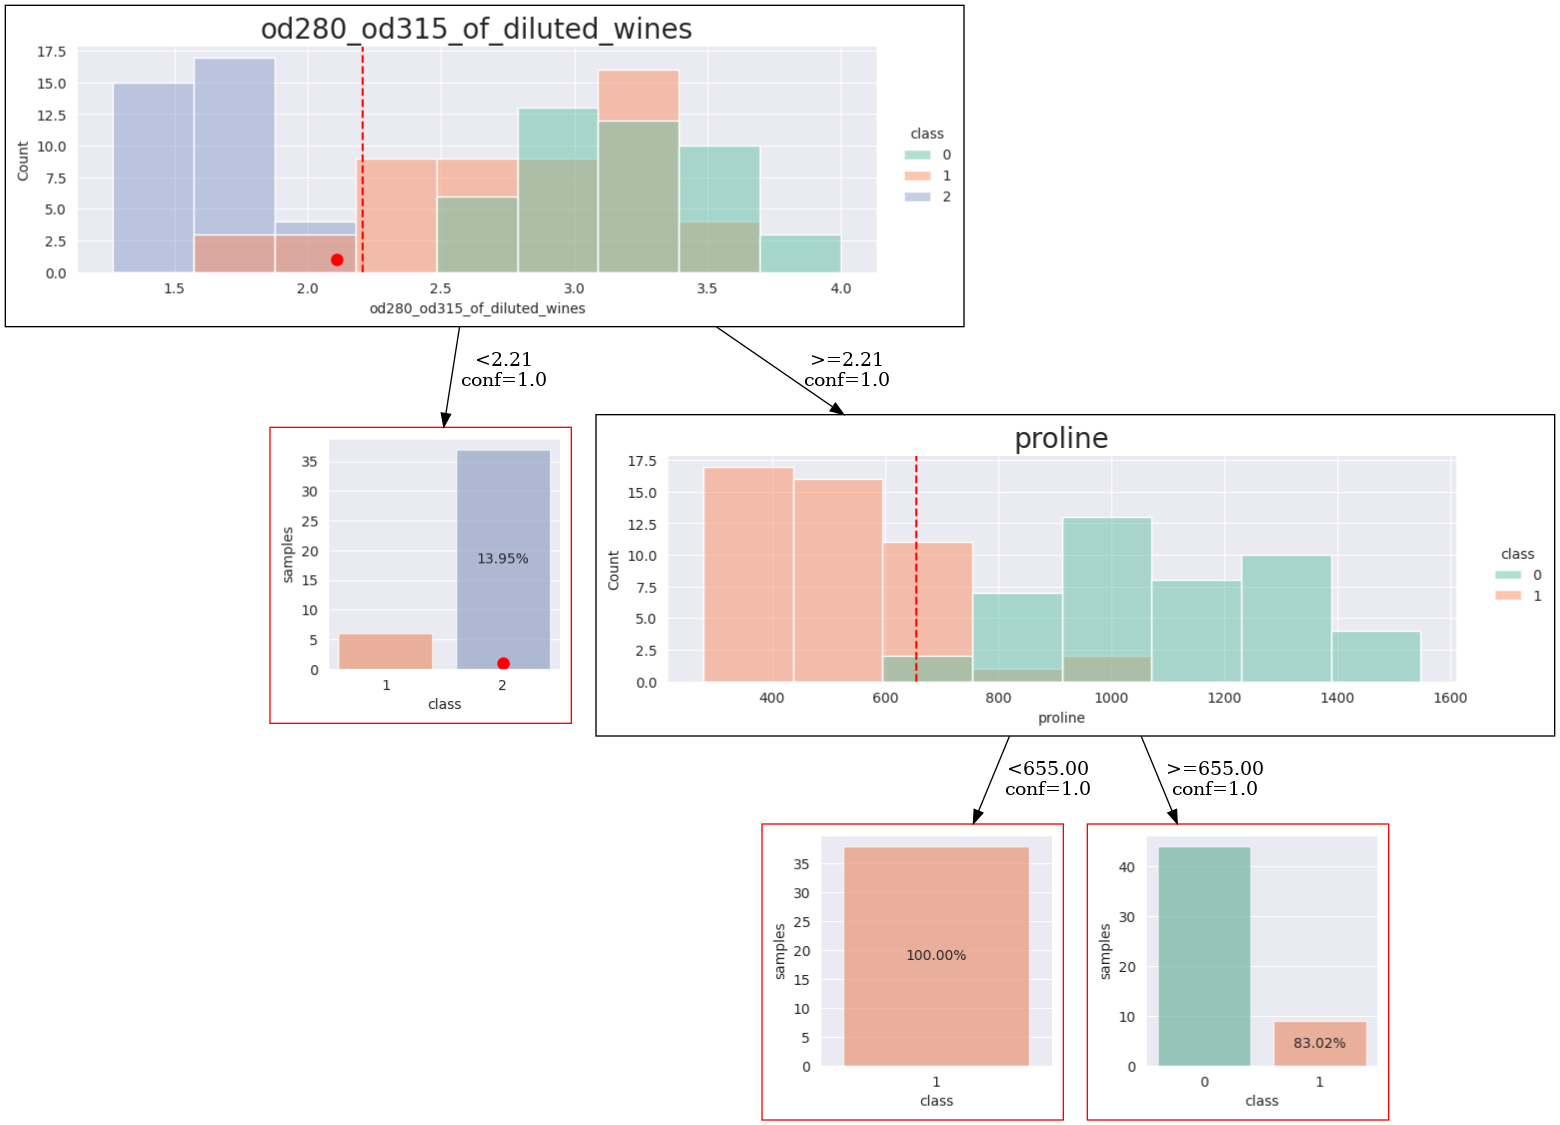

In [510]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image
i2edf = pd.DataFrame(i2e, columns=features)
i2edf[target] =clf.predict(i2edf.values.reshape(1,-1))[0]
lux.uid3.tree.save_dot('tree-wine.dot',fmt='.2f',visual=True, background_data=train,  instance2explain=i2edf)
gvz=graphviz.Source.from_file('tree-wine.dot')
!dot -Tpng tree-wine.dot > tree-wine.png
Image('tree-wine.png')

## Without SHAP

In [511]:
#pick some instance from datasetr
i2e = train[features].sample(1, random_state=42).values

#train lux on neighbourhood equal 20 instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


['IF od280_od315_of_diluted_wines <2.2050000429153442 AND malic_acid >=1.6249999701976776 THEN class = 2 # 1.0\n']

In [512]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.8666666666666667


In [513]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')

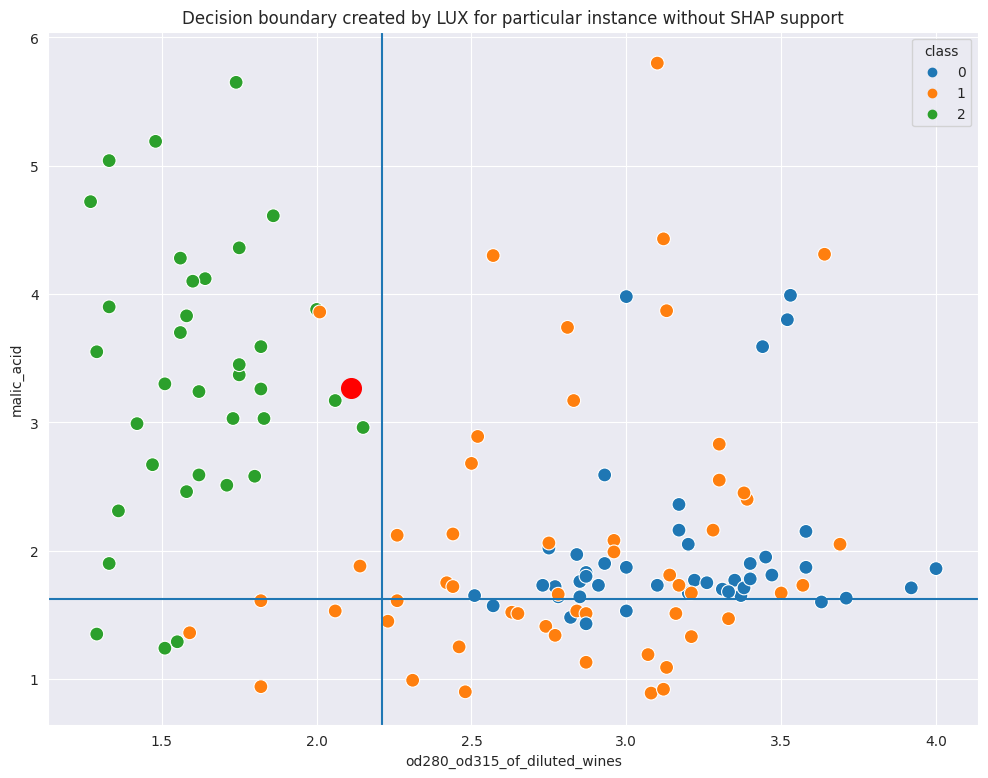

In [514]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='od280_od315_of_diluted_wines',y='malic_acid', data=train[['od280_od315_of_diluted_wines','malic_acid',target]],hue=target,s=100)
plt.scatter(data=pd.DataFrame(i2e,columns=features),x='od280_od315_of_diluted_wines',y='malic_acid', marker='o',color='r', s=200)
graph.axvline(2.21)
graph.axhline(1.62)
plt.title('Decision boundary created by LUX for particular instance without SHAP support')
plt.savefig('noshap-wine-scatter.png', format='png',bbox_inches='tight')
plt.show()

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

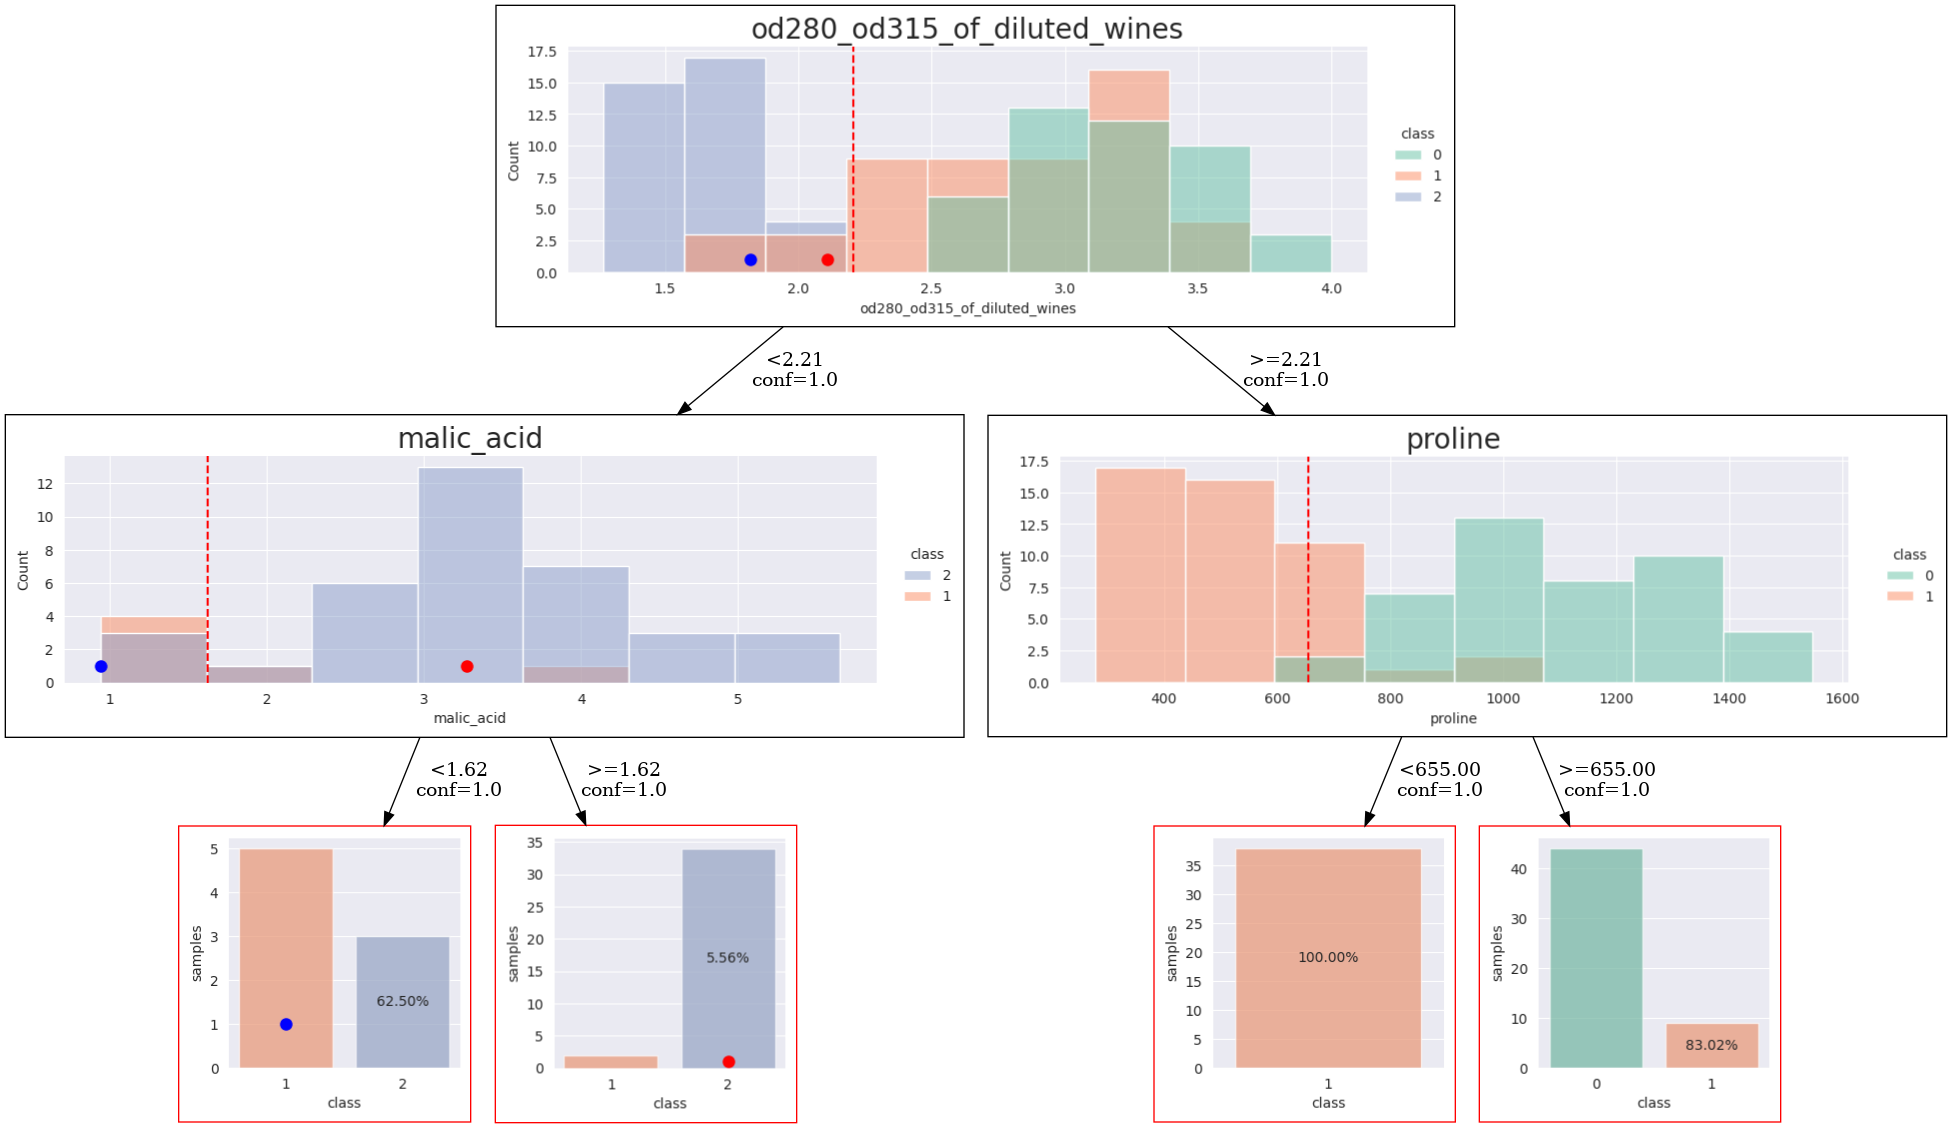

In [515]:
cf = lux.counterfactual(np.array(i2e), train[features], counterfactual_representative='medoid', topn=1)[0]
lux.visualize(data=train,target_column_name='class',instance2explain=i2e,counterfactual=cf,filename='tree-wine.dot' )
gvz=graphviz.Source.from_file('tree-wine.dot')
!dot -Tpng tree-wine.dot > tree-wine.png
Image('tree-wine.png')

## With SHAP

In [516]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(clf, train[features])
shap_values = explainer.shap_values(train[features],check_additivity=False)

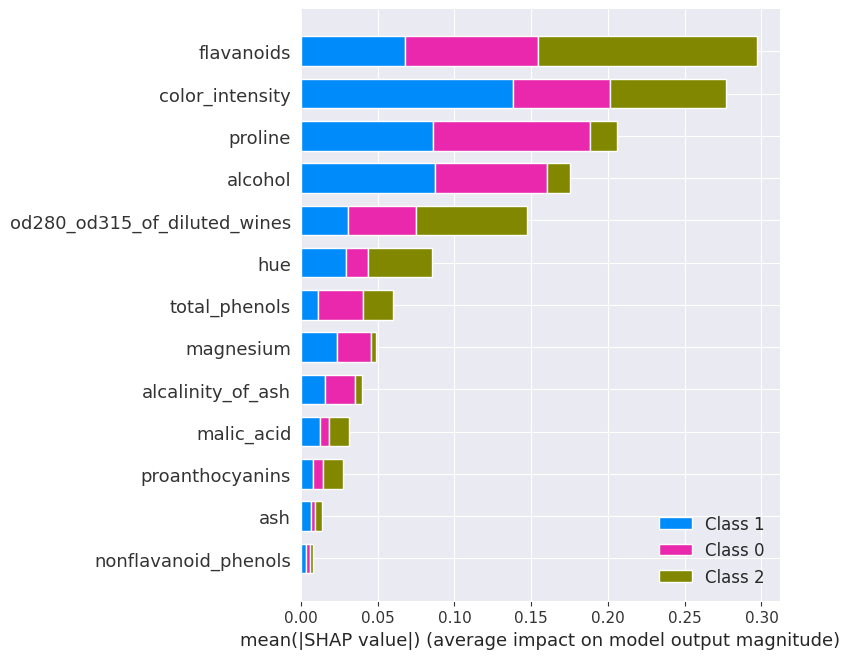

In [517]:
plt.figure()
shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None, show=False)
plt.savefig('shap-wine.png', format='png',bbox_inches='tight')
plt.show()

In [518]:
#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, classifier=clf, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=i2e,class_names=[0,1,2],discount_importance=False)

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


['IF color_intensity >=3.424999952316284 AND flavanoids <1.4900000095367432 THEN class = 2 # 1.0\n']

In [519]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9111111111111111


In [520]:
#prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

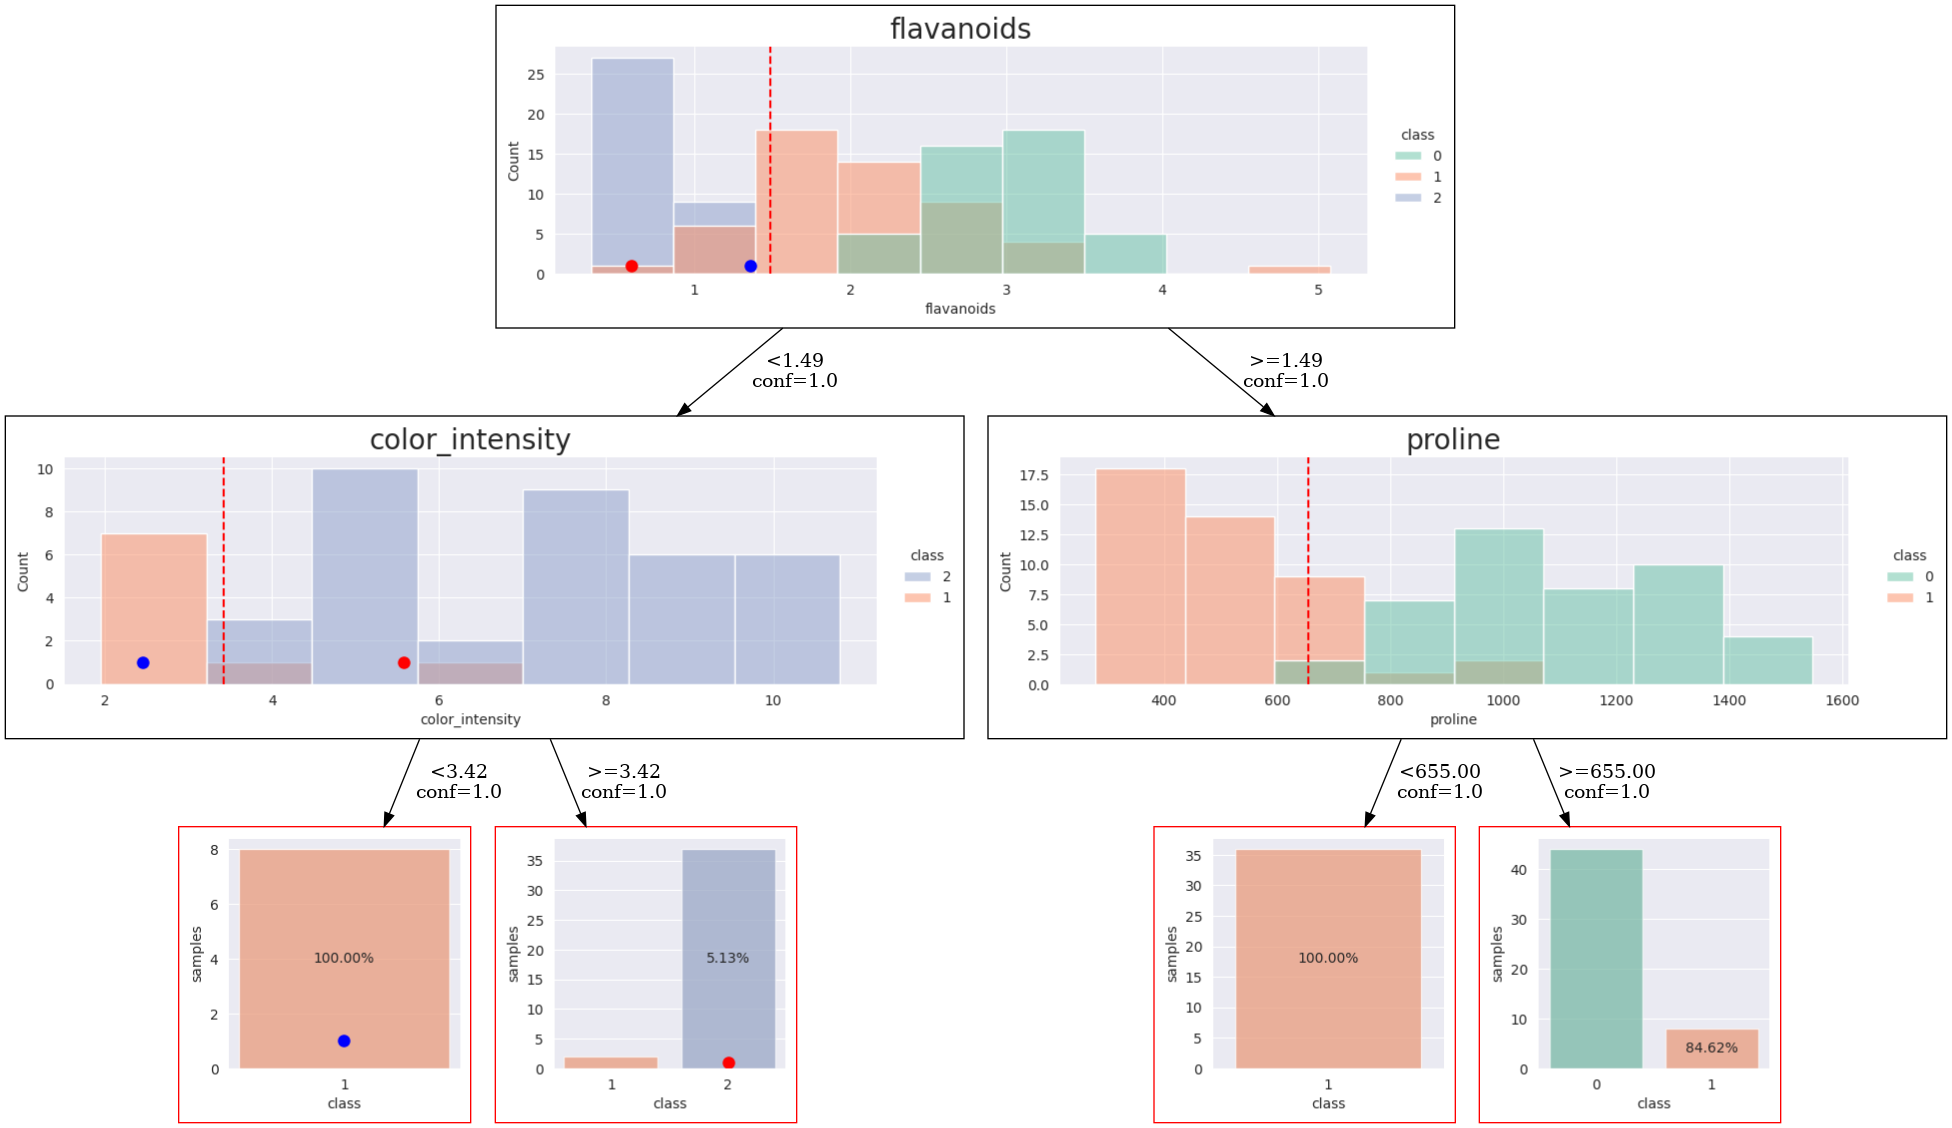

In [521]:
import graphviz
from IPython.display import SVG, Image
cf = lux.counterfactual(np.array(i2e), train[features], counterfactual_representative='medoid', topn=1)[0]
cfdf = pd.DataFrame(cf['counterfactual']).T
cfdf[target] = clf.predict(cfdf.values.reshape(1,-1))[0]
i2edf = pd.DataFrame(i2e, columns=features)
i2edf[target] =clf.predict(i2edf.values.reshape(1,-1))[0]
lux.uid3.tree.save_dot('tree-wine-shap.dot',fmt='.2f',visual=True, background_data=train,  instance2explain=i2edf,counterfactual=cfdf)
gvz=graphviz.Source.from_file('tree-wine-shap.dot')
!dot -Tpng tree-wine-shap.dot > tree-wine-shap.png
Image('tree-wine-shap.png')

In [543]:
cf

{'rule': {'color_intensity': ['<3.424999952316284'],
  'flavanoids': ['<1.4900000095367432']},
 'prediction': '1',
 'confidence': 1.0,
 'covered':      alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
 69     12.21        1.19  1.75               16.8      151.0           1.85   
 96     11.81        2.12  2.74               21.5      134.0           1.60   
 101    12.60        1.34  1.90               18.5       88.0           1.45   
 77     11.84        2.89  2.23               18.0      112.0           1.72   
 70     12.29        1.61  2.21               20.4      103.0           1.10   
 59     12.37        0.94  1.36               10.6       88.0           1.98   
 92     12.69        1.53  2.26               20.7       80.0           1.38   
 
      flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity  \
 69         1.28                  0.14             2.50             2.85   
 96         0.99                  0.14             1.56     

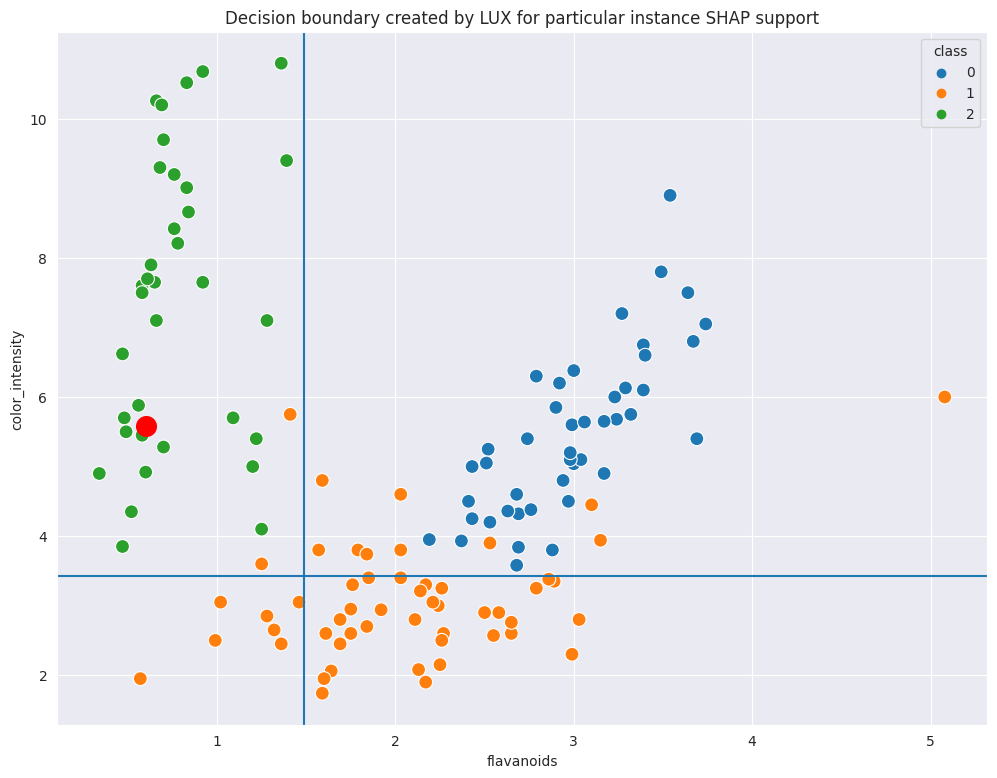

In [522]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='flavanoids',y='color_intensity', data=train[['flavanoids','color_intensity',target]],hue=target,s=100)
graph.axvline(1.49)
graph.axhline(3.425)
plt.scatter(data=pd.DataFrame(i2e,columns=features),x='flavanoids',y='color_intensity', marker='o', color='r',s=200)
plt.title('Decision boundary created by LUX for particular instance SHAP support')
plt.savefig('shap-wine-scatter.png', format='png',bbox_inches='tight')
plt.show()

# Breast cancer

In [523]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
cancer = datasets.load_breast_cancer()

In [524]:
features = [f.replace(" ","_") for f in cancer['feature_names']]
target = 'calss'
rs=42

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_cancer = pd.DataFrame(cancer.data,columns=features)
df_cancer[target] = cancer.target

#train classifier
train, test = train_test_split(df_cancer, random_state=rs)
clf = RandomForestClassifier(random_state=42)#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

0.965034965034965

## Without predictor uncertinaty

In [525]:
#pick some instance from datasetr
i2e = train[features].sample(1, random_state=42).values

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1])

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


['IF worst_concave_points <0.1423499956727028 AND worst_radius <16.755000114440918 THEN class = 1 # 0.9076923076923077\n']

In [526]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.916083916083916


In [527]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

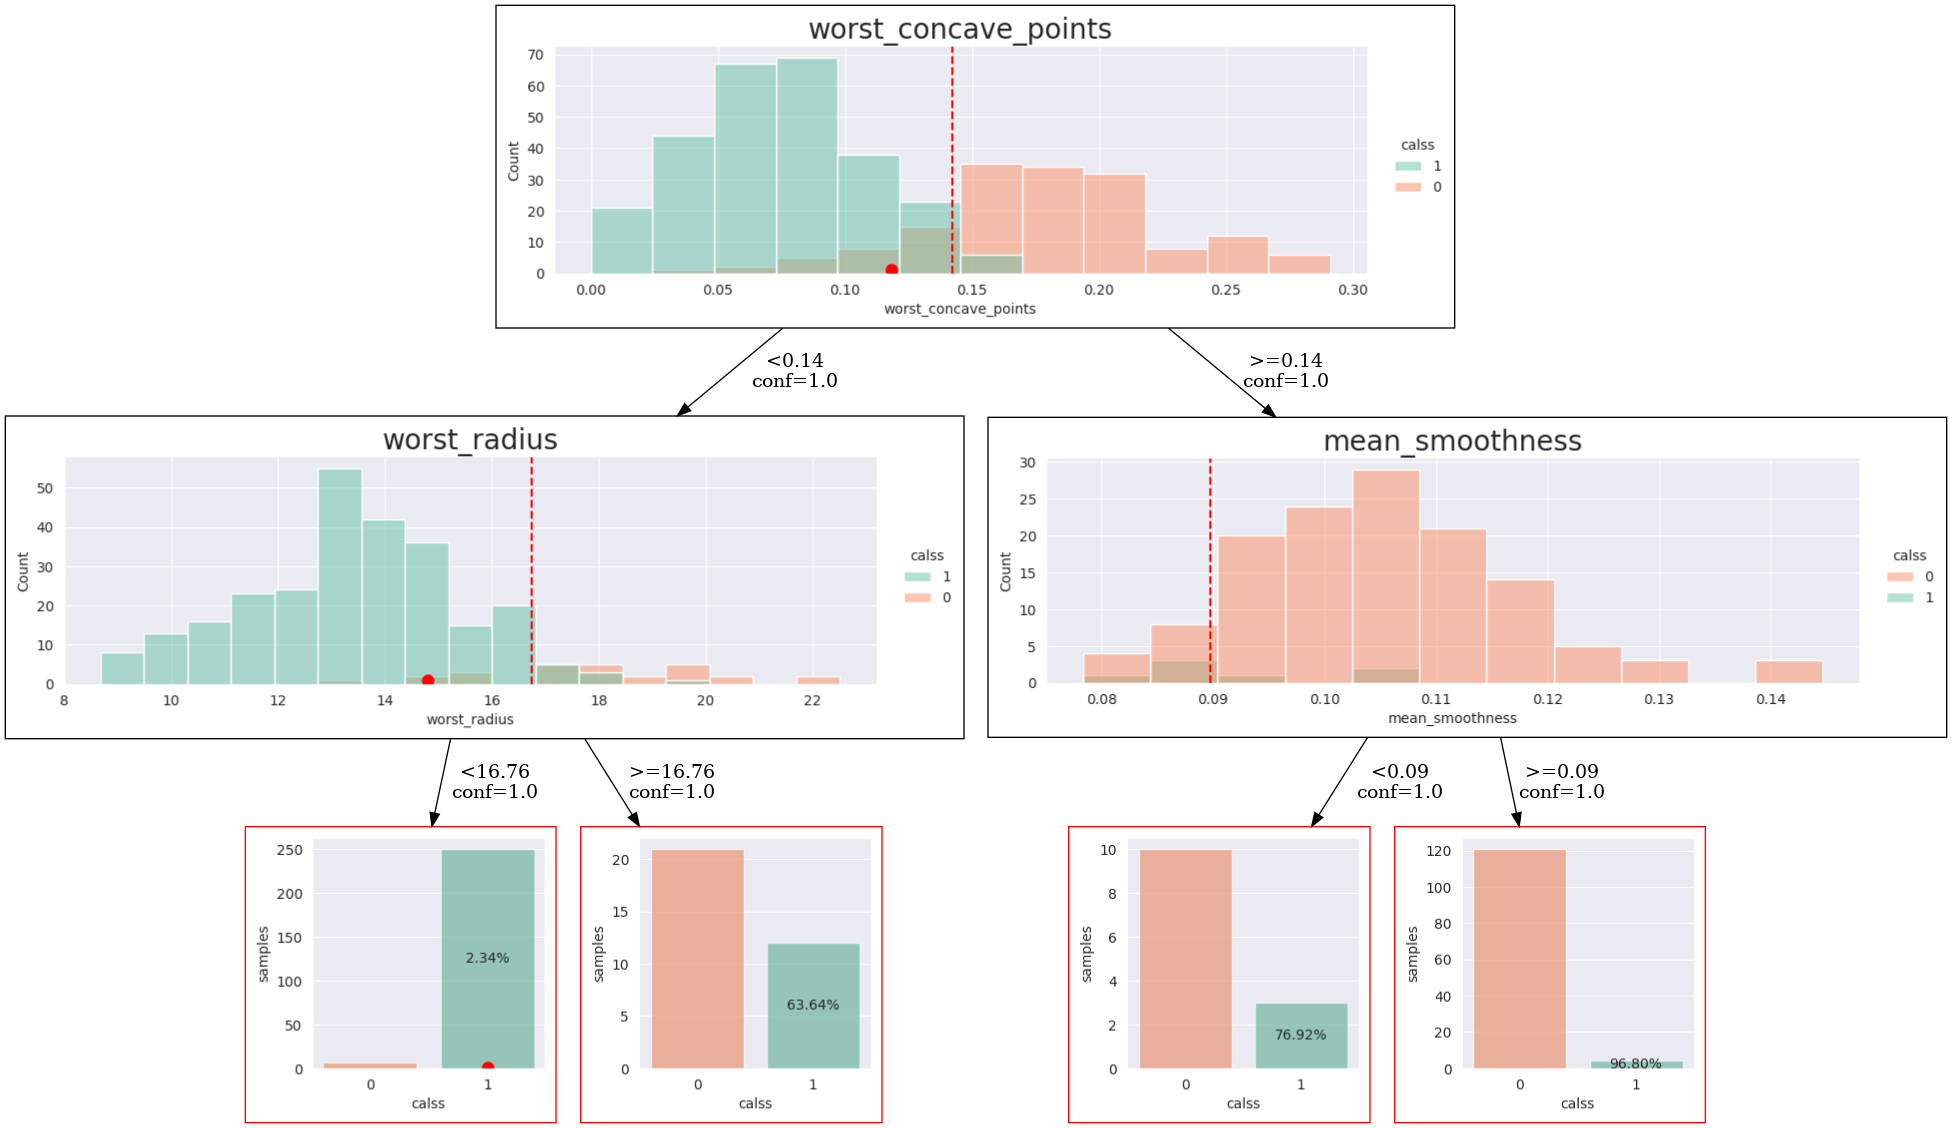

In [528]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image
i2edf = pd.DataFrame(i2e, columns=features)
i2edf[target] =clf.predict(i2edf.values.reshape(1,-1))[0]
lux.uid3.tree.save_dot('tree-breast.dot',fmt='.2f',visual=True, background_data=train,  instance2explain=i2edf)
gvz=graphviz.Source.from_file('tree-breast.dot')
!dot -Tpng tree-breast.dot > tree-breast.png
Image('tree-breast.png')

## Without SHAP

In [529]:
#pick some instance from datasetr
i2e = train[features].sample(1, random_state=42).values

#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1])

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


['IF worst_concave_points <0.14305000007152557 AND worst_radius <16.755000114440918 THEN class = 1 # 0.9830508474576272\n']

In [530]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9230769230769231


In [531]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

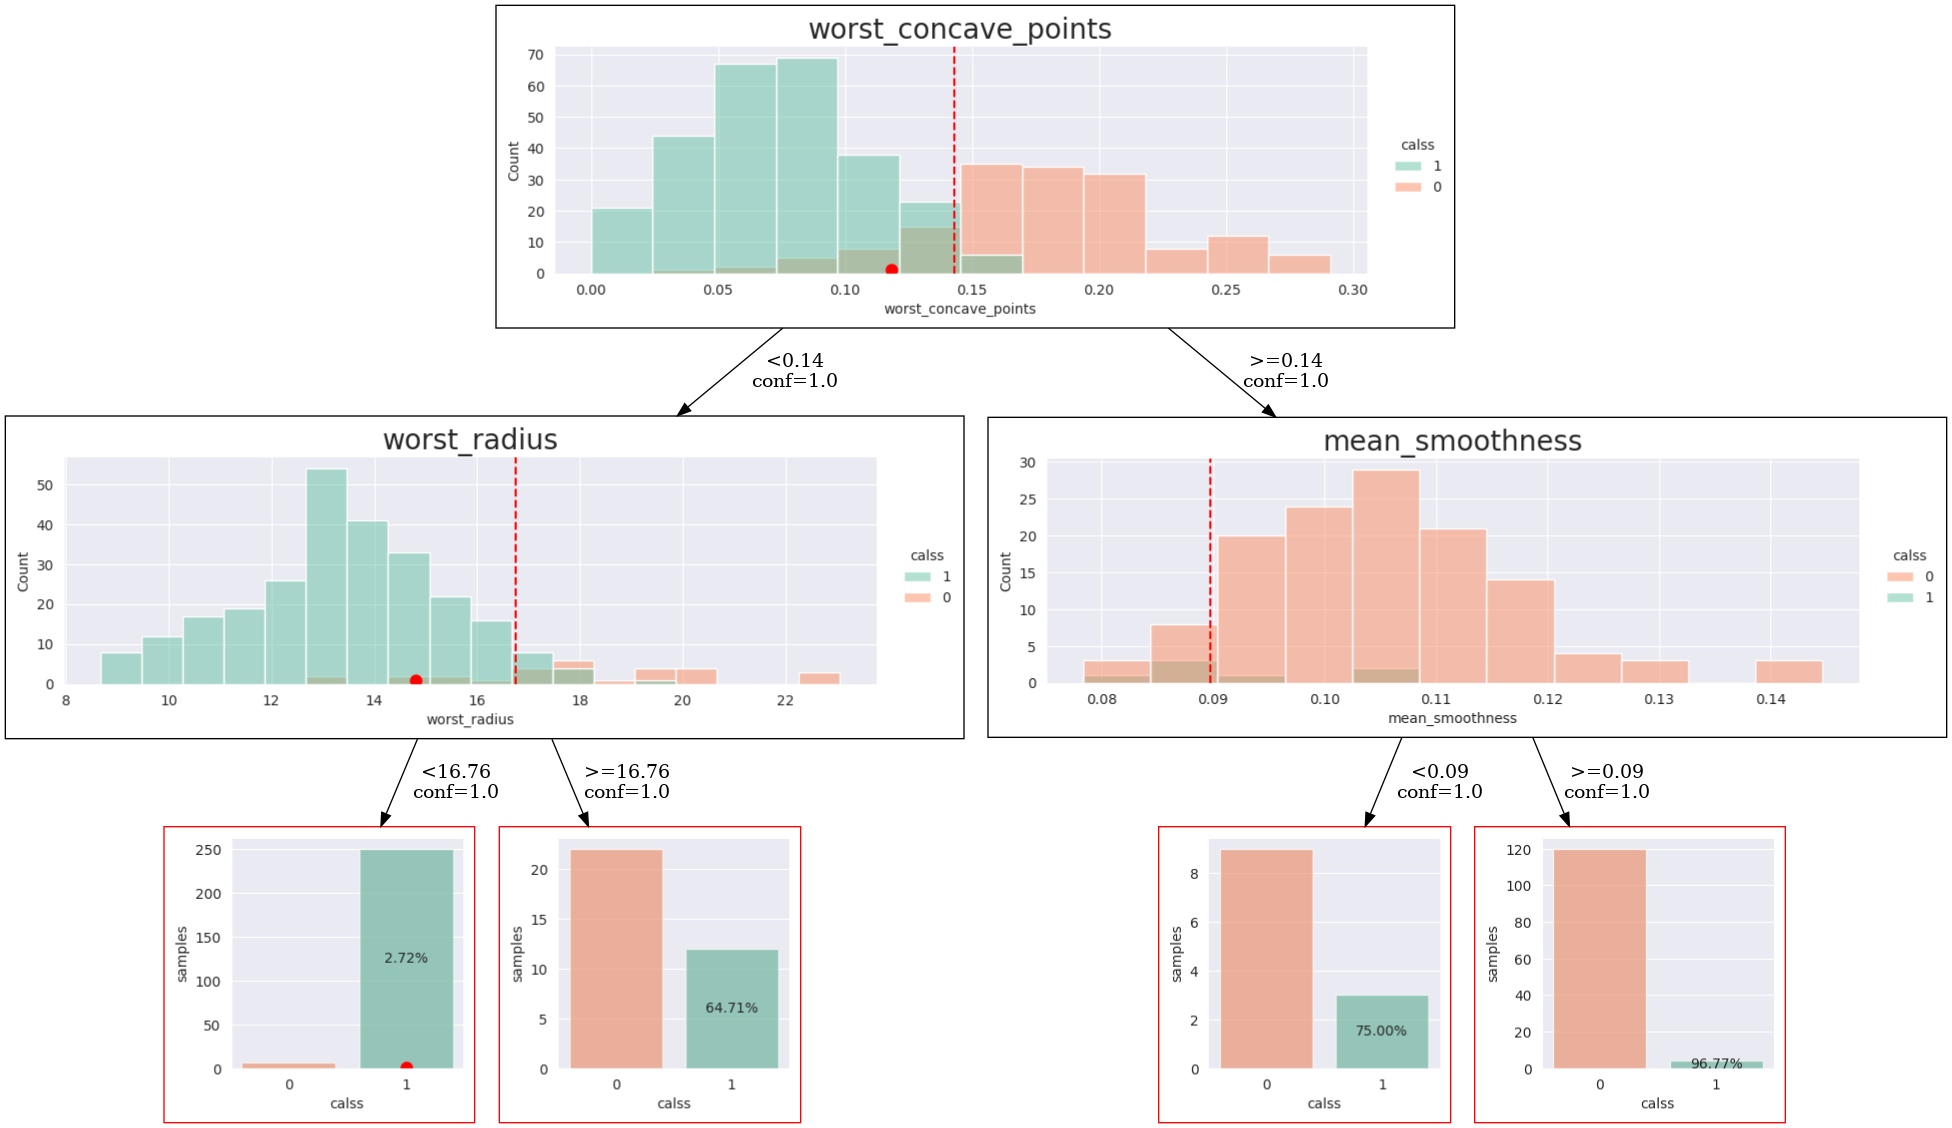

In [532]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image
i2edf = pd.DataFrame(i2e, columns=features)
i2edf[target] =clf.predict(i2edf.values.reshape(1,-1))[0]
lux.uid3.tree.save_dot('tree-breast.dot',fmt='.2f',visual=True, background_data=train,  instance2explain=i2edf)
gvz=graphviz.Source.from_file('tree-breast.dot')
!dot -Tpng tree-breast.dot > tree-breast.png
Image('tree-breast.png')

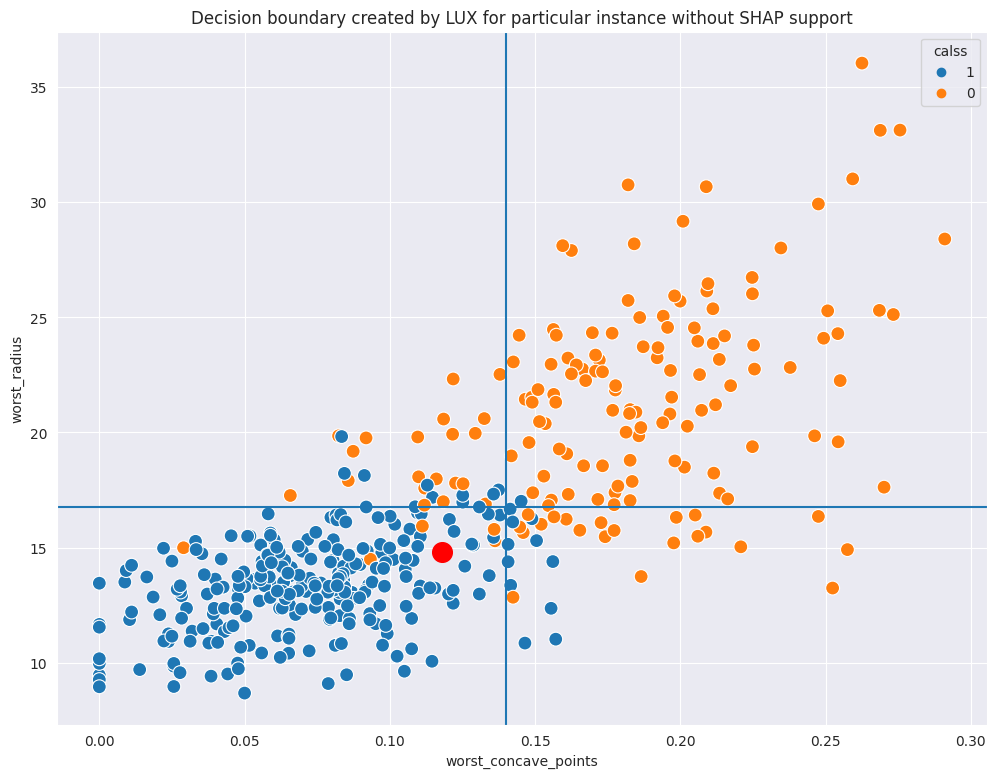

In [533]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='worst_concave_points',y='worst_radius', data=train[['worst_concave_points','worst_radius',target]],hue=target,s=100)
graph.axvline(0.14)
graph.axhline(16.76)
plt.scatter(data=pd.DataFrame(i2e,columns=features),x='worst_concave_points',y='worst_radius', marker='o',color='r', s=200)
plt.title('Decision boundary created by LUX for particular instance without SHAP support')
plt.show()

## With SHAP
You will see that the result is almost the same, but now the explainer uses the same set of features as blackbox model, minimizing the Rashomon effect

In [534]:
import shap
shap.initjs()
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees


explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(train[features],check_additivity=True)

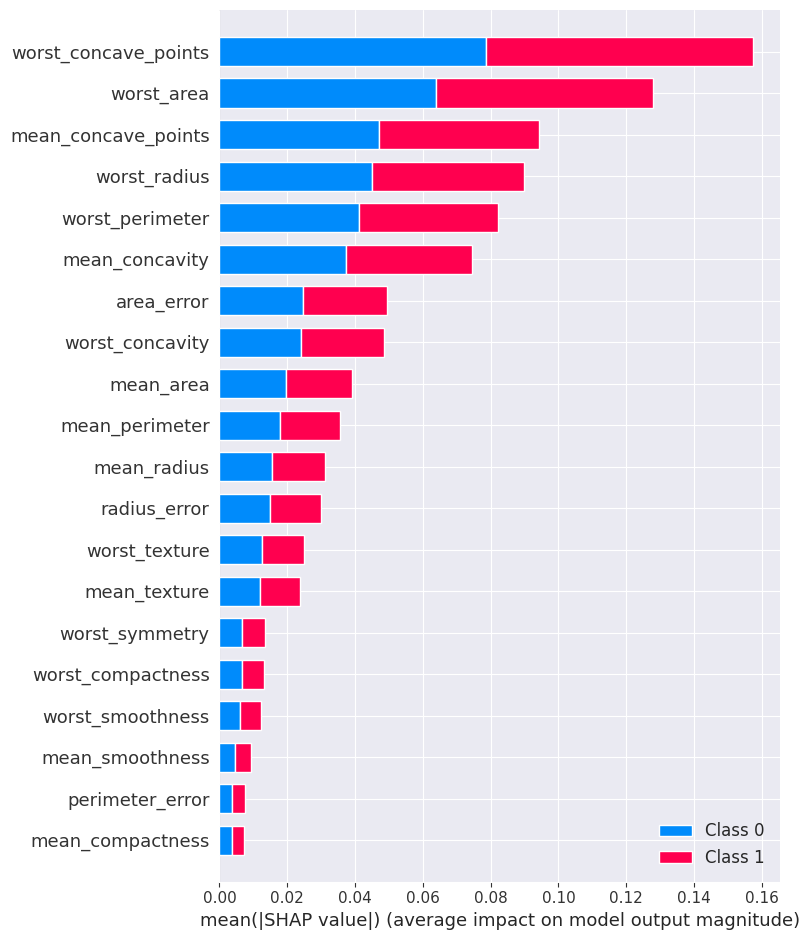

In [535]:
shap.summary_plot(shap_values,train[features])#, features=None, feature_names=features, max_display=None)

In [536]:
#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, classifier=clf, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=i2e,class_names=[0,1],discount_importance=False)

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


['IF worst_area <839.6499938964844 AND worst_concave_points <0.14305000007152557 THEN class = 1 # 0.9827586206896551\n']

In [537]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9370629370629371


In [538]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('tree.dot')
# graphviz.Source.from_file('tree.dot')

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

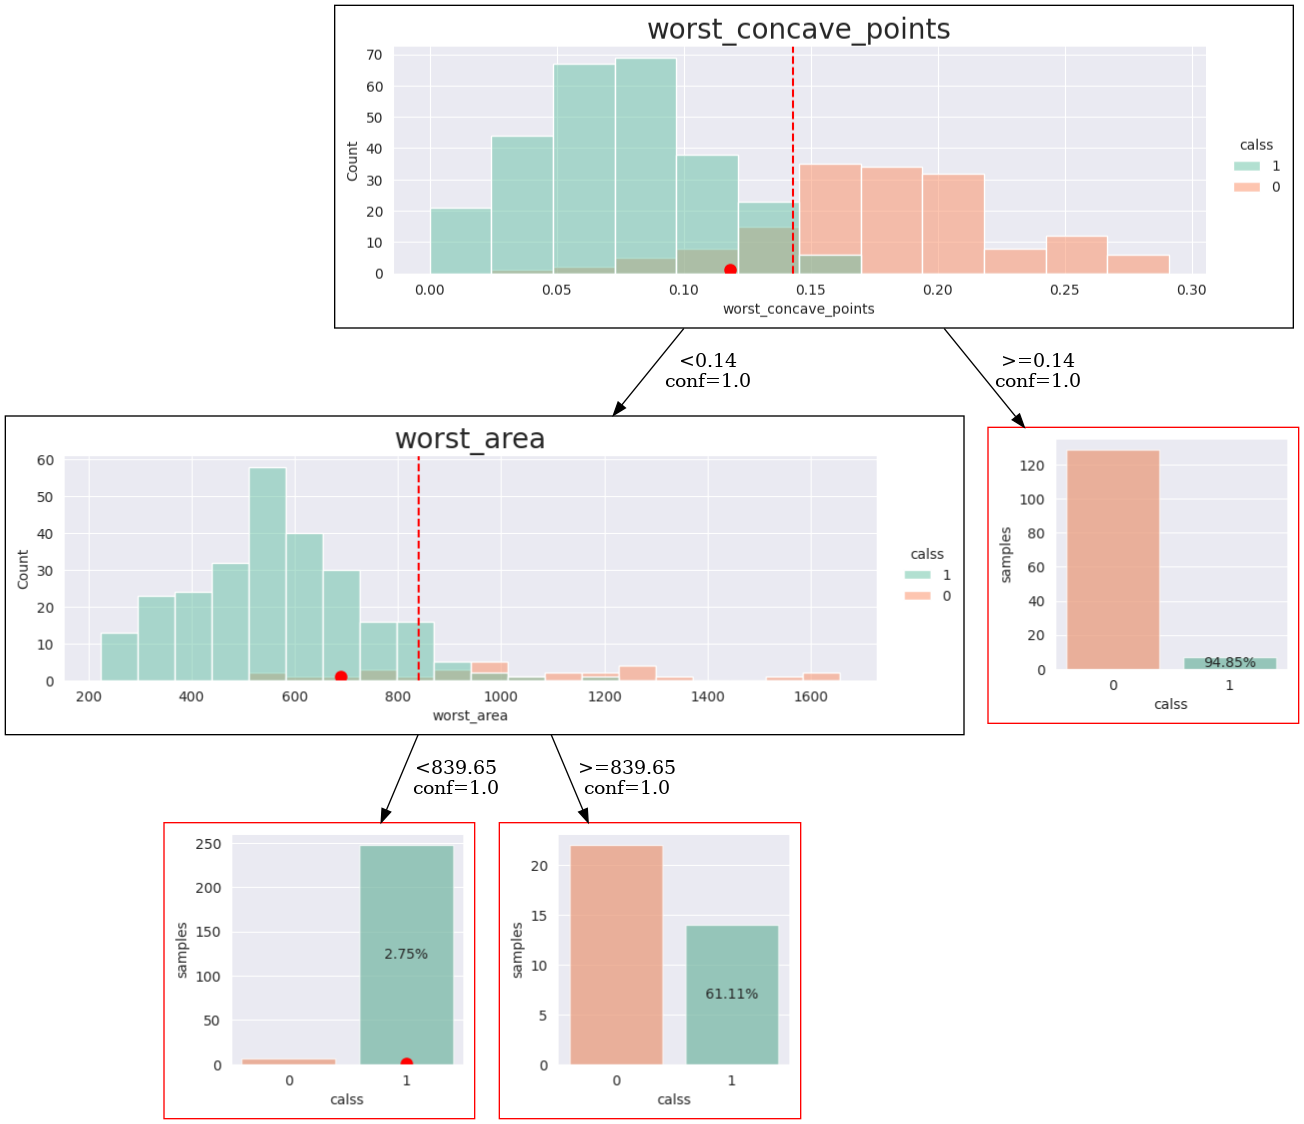

In [539]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image
i2edf = pd.DataFrame(i2e, columns=features)
i2edf[target] =clf.predict(i2edf.values.reshape(1,-1))[0]
lux.uid3.tree.save_dot('tree-breast-shap.dot',fmt='.2f',visual=True, background_data=train,  instance2explain=i2edf)
gvz=graphviz.Source.from_file('tree-breast-shap.dot')
!dot -Tpng tree-breast-shap.dot > tree-breast-shap.png
Image('tree-breast-shap.png')

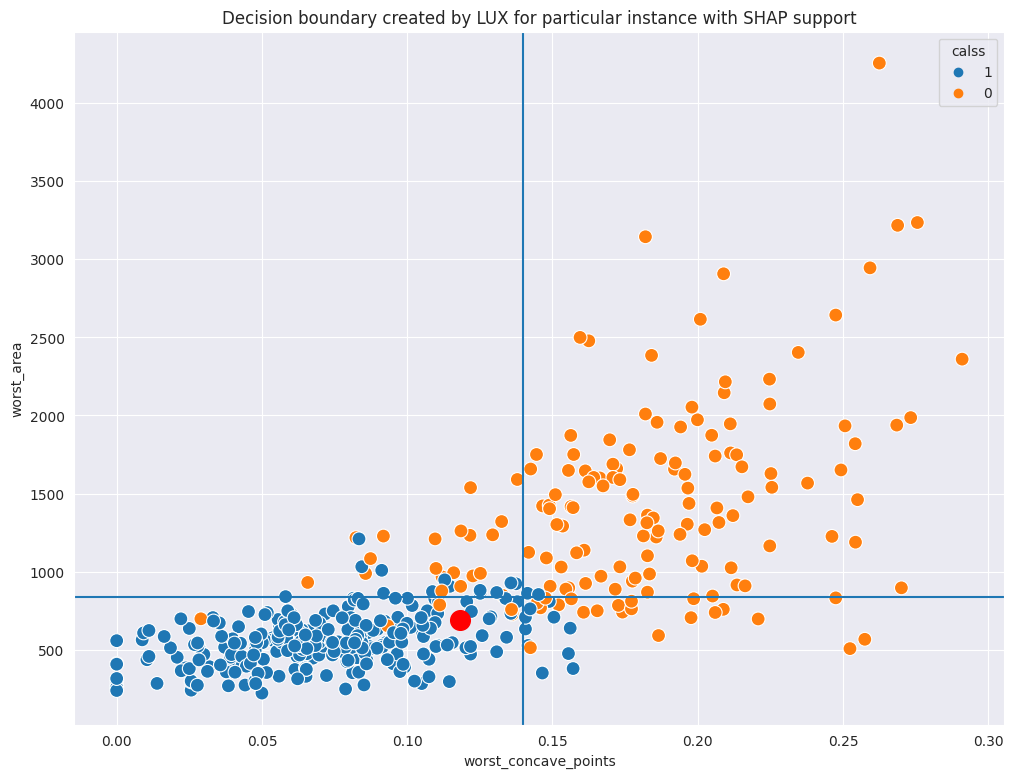

In [540]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='worst_concave_points',y='worst_area', data=train[['worst_concave_points','worst_area',target]],hue=target,s=100)
graph.axvline(0.14)
graph.axhline(839.7)
plt.scatter(data=pd.DataFrame(i2e,columns=features),x='worst_concave_points',y='worst_area', marker='o',color='r', s=200)
plt.title('Decision boundary created by LUX for particular instance with SHAP support')
plt.show()